# Описание проекта

В каршеринговую компанию поступил заказ: создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

**Цель:** создать модель предсказания ДТП.   
**Задачи:**   
1. Загрузить таблицы sql
2. Первичное исследование таблиц
3. Статистический анализ факторов ДТП
4. Сздать модель оценки водительского риска
5. Найти лучшую модель
6. Проверить лучшую модель в работе

## Шаг 1. Загрузить таблицы sql

Импортируем необходимые библиотеки.

In [1]:
!pip install sqlalchemy
!pip install phik
!!pip install category_encoders
!pip install optuna-integration[sklearn]
!pip install scikit-learn==1.4.2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import sklearn

from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution
from optuna.integration import OptunaSearchCV
from category_encoders import LeaveOneOutEncoder
from phik import phik_matrix
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_recall_curve, precision_score, recall_score

In [3]:
RANDOM_STATE = 42

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

Проверим какие таблицы содержатся в базе данных.

In [6]:
tables_query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema='public'
'''
pd.read_sql(tables_query, con=engine)

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


In [7]:
# case_ids
display(pd.read_sql('''SELECT * FROM case_ids LIMIT 5''', con=engine))

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Таблица `case_id` содержит уникальнеые идентификаторы ДТП происшествия и столбец с колонкой, где указан год добавления происшествия в базу.  

## Промежуточный вывод

**Цель:** загрузить таблицы sql.  
1. Импортированы библиотеки
2. Подключение к базе данных.
3.  Таблица `case_id` лишняя, в будущем не будет использована.

## Шаг 2. Первичное исследование таблиц

В прошлом шаге обнаружена лишняя таюлица с номерами ДТП и годом их внесепния в базу данных. Принято решение не использовать эту таблицу.

Выведем первые 5 строк кажой таблицы.

In [8]:
# collisions
display(pd.read_sql('''SELECT * FROM collisions LIMIT 5''', con=engine))

# parties
display(pd.read_sql('''SELECT * FROM parties LIMIT 5''', con=engine))

# vehicles
display(pd.read_sql('''SELECT * FROM vehicles LIMIT 5''', con=engine))

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


`vehicle` столбцы соответсвуют описанию. `parties` в описании отсутсвует столбец id. `collisions` найден лишний столбец control_device, который не указан в ТЗ, возьмем его для исследования.

`collisions`:
- в столбце intersections вместо заявленных Y/N содержатся значения 1/0

`parties`:
- в столбце party_type вместо 1/2/3...6 используются текстовые значения

Проверим ключи таблиц на уникальные значения. 

In [9]:
display(pd.read_sql('''SELECT COUNT(*) AS all_ids, COUNT(DISTINCT case_id) AS unique_id FROM case_ids''', con=engine))
display(pd.read_sql('''SELECT COUNT(*) AS all_collisions, COUNT(DISTINCT case_id) AS unique_id FROM collisions''', con=engine))
display(pd.read_sql('''SELECT COUNT(*) AS all_parties, COUNT(DISTINCT case_id) AS unique_id FROM parties''', con=engine))
pd.read_sql('''SELECT COUNT(*) AS all_vehicles, COUNT(DISTINCT case_id) AS unique_id FROM vehicles''', con=engine)

,all_ids,unique_id
0,1400000,1400000


,all_collisions,unique_id
0,1400000,1400000


,all_parties,unique_id
0,2752408,1400000


,all_vehicles,unique_id
0,1021234,792642


Всего зарегистрировано 1'400'000 ДТП. В таблице с информацией о происшествиях количество записей соответсвует количеству зарегистрированных ДТП. В таблице с данными участников происшествий логично, что количество участников будет больше, чем ДТП. В таблице с описанием автомобиля всего 792'642 ДТП. В таблице с транспортом происшествий почти в 2 раза меньше чем машин, что логично, в аварии чаще всего участвует 1-2 машины. При соединении таблиц `parties` и `vehicle` используем два ключа - case_id and party_number. Для объедлинения `collisions` и `parties` - case_id.

## Промежуточный вывод

**Цель:** первично исследовать таблицы.
1. Обнаружен лишний столбец в `collisions` control_device
2. Обнаружены несоответсвия в формате заполнения столбцов, но незначительные
3. Установлено наличие необходимых ключей для объединения таблиц и навигации.

## Шаг 3. Статистический анализ факторов ДТП

Выясним за какой период времени у нас предоставлена информация о ДТП.

In [10]:
pd.read_sql('''
SELECT MIN(collision_date) AS min_date,
       MAX(collision_date) AS max_date
FROM collisions
''', con=engine)

,min_date,max_date
0,2009-01-01,2020-07-26


Данные о ДТП пердставлены с началка января 2009 года по конец июля 2020 года.

Исследуем распределенние данных по годам.

In [11]:
year = pd.read_sql('''
SELECT EXTRACT (YEAR FROM COLLISION_DATE)::int AS year,
       COUNT(*) AS total_collision
FROM collisions
GROUP BY year
ORDER BY year
''', con=engine)
year

,year,total_collision
0,2009,426228
1,2010,416490
2,2011,402428
3,2012,154547
4,2013,305
5,2020,2


Исседуем данные по месяцам.

In [12]:
month_per_year = pd.read_sql('''
SELECT EXTRACT (YEAR FROM collision_date)::int AS year,
       EXTRACT(MONTH FROM collision_date)::int AS month,
       COUNT(*) AS total_collision
FROM collisions
GROUP BY year, month
ORDER BY year, month
''', con=engine)
month_per_year

,year,month,total_collision
0,2009,1,35062
1,2009,2,34480
2,2009,3,36648
3,2009,4,35239
4,2009,5,36916
5,2009,6,34202
6,2009,7,35161
7,2009,8,34508
8,2009,9,35555
9,2009,10,37835


Данные представленны в полной мере только до 2012 года включительно. За 2012 год данных с января по декабрь становится все меньше и меньше. Начиная с апреля 2012 года данные ощутимо ниже, чем за такие же месяца прошлых лет. В принципе, можно оставить данные за 2012 год до мая включительно.

Исследуем распределение по месяцам.

In [13]:
monthly_data = pd.read_sql('''
SELECT 
    EXTRACT(MONTH FROM collision_date)::int AS month,
    COUNT(*) AS collisions_count
FROM collisions
WHERE (EXTRACT(YEAR FROM collision_date)::int NOT IN (2013, 2020)) AND
    NOT (EXTRACT(YEAR FROM collision_date)::int = 2012 AND EXTRACT(MONTH FROM collision_date)::int <= 5)
GROUP BY month
ORDER BY month
''', con=engine)
monthly_data

,month,collisions_count
0,1,99880
1,2,98373
2,3,107036
3,4,101032
4,5,105148
5,6,102593
6,7,102225
7,8,104089
8,9,105159
9,10,112237


Визуализируем распределение.

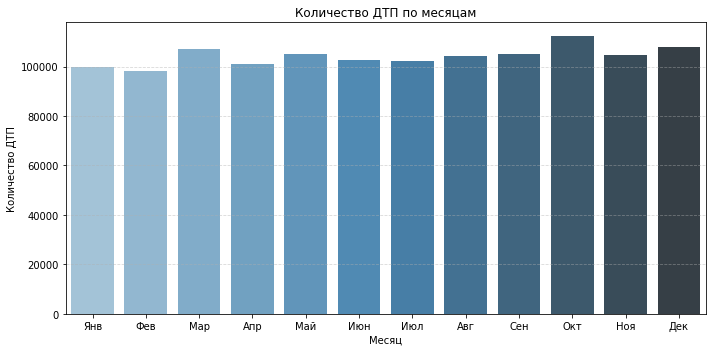

In [14]:
plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_data, x='month', y='collisions_count', palette='Blues_d')

plt.title('Количество ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.xticks(ticks=range(0, 12), labels=[
    'Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
    'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'
])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Наибольшгее количество ДТП зарегистрировано в Октябре (112'237), наименьшее количество в Феврале (98'373).  Если рассматривать сезоны, то в зимние периоды наименьшее количество дорожных происшествий, а осенью наибольшее. Вообще, осенью (322'166) и весной (308'773) больше ДТП, чем в зимнее и летние периоды. Возможно, это связано с погодными условиями.

<u>Аналитическиe задачи:</u>
1. Проанализировать сезонность ДТП и выяснить, сопровождаются ли пиковые месяцы ухудшением погодных условий.
2. Проанализировать, насколько часто участники ДТП использовали телефон во время происшествия и связано ли это с их виновностью.
3. Определить топ-3 наиболее частых причины ДТП.
4. Исследовать зависимость между освещением дороги, состоянием дороги и количеством ДТП.
5. Выявить топ-10 регионов с наибольшим числом ДТП и определить, какие типы дорог в них наиболее часто связаны с авариями.
6. Выявить, есть ли связь между возрастом ТС и вероятностью стать виновником аварии.
7. Анализ серьёзности повреждений в зависимости от трезвости участника.

Реализуем решение аналитических задач под номерами 6 и 7.

**Задача 6.Выявить, есть ли связь между возрастом ТС и вероятностью стать виновником аварии.**

Объединим таблицы `vehicles` и `parties` по ключам case_id и party_number. Выведем значения возраста автомобиля, среднее арифметическое значения виновности и количество участников с таким возрастом автомобиля. Данные сгруппированы по возрасту автомобиля.

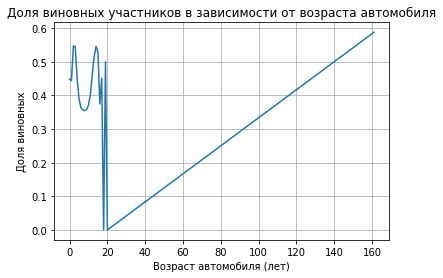

In [15]:
six = pd.read_sql(
'''
SELECT
    v.vehicle_age,
    AVG(p.at_fault) AS fault_rate,
    COUNT(*) AS total_participants
FROM vehicles v
JOIN parties p
    ON v.case_id = p.case_id AND v.party_number = p.party_number
GROUP BY v.vehicle_age
ORDER BY v.vehicle_age
'''
, con=engine)

sns.lineplot(data=six, x='vehicle_age', y='fault_rate')
plt.title("Доля виновных участников в зависимости от возраста автомобиля")
plt.xlabel("Возраст автомобиля (лет)")
plt.ylabel("Доля виновных")
plt.grid(True)
plt.show()

In [16]:
six['vehicle_age'].describe()

count     22.000000
mean      16.863636
std       32.757835
min        0.000000
25%        5.250000
50%       10.500000
75%       15.750000
max      161.000000
Name: vehicle_age, dtype: float64

Найден выборос, явно ошибочное значение. Удалим его.

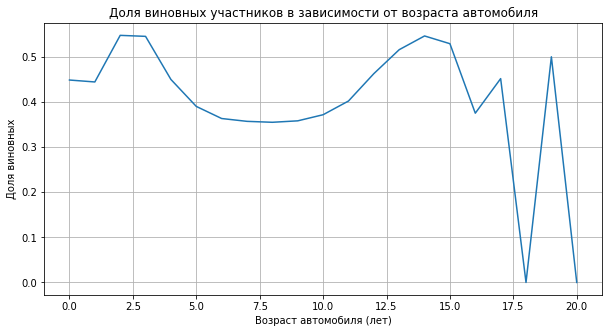

In [17]:
six = six[six['vehicle_age'] <30]

plt.figure(figsize=(10, 5))
sns.lineplot(data=six, x='vehicle_age', y='fault_rate')
plt.title("Доля виновных участников в зависимости от возраста автомобиля")
plt.xlabel("Возраст автомобиля (лет)")
plt.ylabel("Доля виновных")
plt.grid(True)
plt.show()

Самая высокая доля виновных наблюдается среди водителей на новых автомобилях (0–3 года), что может быть связано либо с переоценкой своих возможностей, либо с возрастом водителей. Снижение доли виновных отмечается у автомобилей 4–10 лет, затем — постепенный рост. Резкие колебания после 17 лет, вероятно, вызваны малым количеством таких автомобилей в выборке.

**Задача 7. Анализ серьёзности повреждений в зависимости от трезвости участника.**

Объединим таблицы `collisions` и `parties` по ключу case_id. Выведем столбец party_sobriety (состояние трезвости участника) и collision_damage (уровень повреждений при ДТП), так же считаем количество записей для каждой уникальной пары значений party_sobriety и collision_damage. Группировка по состоянию участника и уровню повреждений для подсчёта количества случаев.
Итоговая таблица сортируется по убыванию общего количества total.

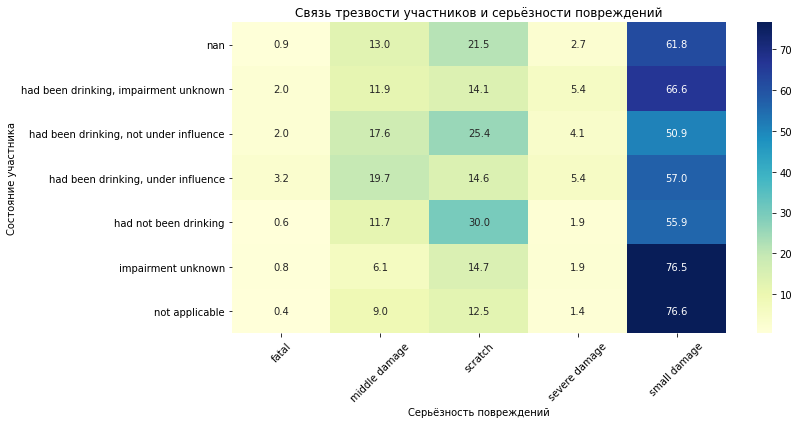

In [18]:
seven = pd.read_sql(
'''
SELECT
    p.party_sobriety,
    c.collision_damage,
    COUNT(*) AS total
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
WHERE (EXTRACT(YEAR FROM collision_date)::int NOT IN (2013, 2020)) AND
    NOT (EXTRACT(YEAR FROM collision_date)::int = 2012 AND EXTRACT(MONTH FROM collision_date)::int <= 5)
GROUP BY p.party_sobriety, c.collision_damage
ORDER BY total DESC
''', con=engine)

pivot = seven.pivot(index='party_sobriety', columns='collision_damage', values='total').fillna(0)
norm = pivot.div(pivot.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
sns.heatmap(norm, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Доля типов повреждений внутри каждой категории трезвости (%)')
plt.title('Связь трезвости участников и серьёзности повреждений')
plt.xlabel('Серьёзность повреждений')
plt.ylabel('Состояние участника')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

В каждой группе состояние участника суммируется до 100%. Наибольшая доля приходится на малые повреждения, а на втором месте — царапины. Максимальное количество ДТП с серьёзными повреждениями (severe damage, other damage) наблюдается среди водителей в состояниях «not been drinking» и «not applicable», что логично, учитывая, что большинство участников — трезвые. При этом водители, которые «had been drinking, under influence», хоть и участвуют в меньшем числе аварий, чаще попадают в ДТП с более тяжёлыми повреждениями (severe damage, middle damage). Кроме того, фатальные исходы встречаются преимущественно именно в этой категории.

## Промежуточный вывод

**Цель:** провести статистический анализ факторов ДТП.
1. Данные представлены с 2009 по середину 2020 года, чаще всего ДТП происходят в осенние месяцы, особенно в октябре.
2. Создано 7 аналитических задач.
3. Реализовано две аналитические задачи, выявлено: 
 - самая высокая доля виновных в ДТП среди водителей новых машин (до 4 лет);
 - самые тяжелые поврежденяи машин у водителей, которые находились в состоянии алкогольного опьянения, самая частая группа аварий с малыми повреждениями.

## Шаг 4. Модель для оценки водительского риска

Создадим отфильтрованный датафрейм для моделирования.

In [19]:
data = pd.read_sql(
'''
SELECT *,
        EXTRACT(DOW FROM collision_date)::int AS weekday
FROM collisions c
JOIN parties p ON c.case_id = p.case_id inner 
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE 
    (EXTRACT(YEAR FROM cast(collision_date AS date))::int = 2012
    AND party_type = 'car'
    AND collision_damage != 'scratch')
''', con=engine)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      56248 non-null  object 
 1   county_city_location         56248 non-null  object 
 2   county_location              56248 non-null  object 
 3   distance                     56248 non-null  float64
 4   direction                    43230 non-null  object 
 5   intersection                 56073 non-null  float64
 6   weather_1                    56080 non-null  object 
 7   location_type                25932 non-null  object 
 8   collision_damage             56248 non-null  object 
 9   party_count                  56248 non-null  int64  
 10  primary_collision_factor     56137 non-null  object 
 11  pcf_violation_category       55482 non-null  object 
 12  type_of_collision            55940 non-null  object 
 13  motor_vehicle_in

Оставим столбцы несущими только важную информацию. Добавили столбец weekday, где 0 - это воскресение, 6 - суббота.

In [20]:
column = [
    'intersection', # перекрестки часто являются местом аварий, система по карте видит маршрут /collisions
    'weather_1', #погода оказывает влияние на видимость и дорооги, система может оценить по сводке погоды /collisions
    'county_location', # разные районы имеют разную плотность движения, качество дорог и инфраструктуру /collisions
    'road_surface', # состоянии дороги, совместимо с погодой /
    'lighting', # время суток и освещенность /collisions
    'control_device', # работа светофоров /collisions
    'collision_time', # время поездки /collisions
    'weekday', # день недели /collisions
    'insurance_premium', # наличие страховки /parties
    'at_fault', # целевой признак /parties
    'cellphone_in_use', # наличие телефона /parties
    'vehicle_transmission', # тип коробки передач, люди могут путаться /vehicles
    'vehicle_age', # возраст автомобиля, изношенность /vehicles
    'vehicle_type' # тип кузова влияет на маневреность машины/vehicles
]
data = data[column]
data.columns = ['intersection', 'weather_1', 'county_location', 'road_surface', 'lighting', 'control_device', 'collision_time', 'weekday', 'insurance_premium',  'at_fault', 'cellphone_in_use', 'vehicle_transmission', 'vehicle_age', 'vehicle_type']
data.head()

,intersection,weather_1,county_location,road_surface,lighting,control_device,collision_time,weekday,insurance_premium,at_fault,cellphone_in_use,vehicle_transmission,vehicle_age,vehicle_type
0,0.0,clear,san diego,dry,dark with street lights,none,01:50:00,5,NaN,1,0.0,manual,3.0,sedan
1,0.0,clear,los angeles,dry,daylight,functioning,17:05:00,0,46.0,0,0.0,auto,2.0,sedan
2,0.0,clear,san mateo,dry,dark with no street lights,none,00:01:00,2,38.0,1,0.0,auto,5.0,sedan
3,0.0,cloudy,orange,wet,dark with no street lights,none,22:30:00,2,36.0,1,0.0,auto,4.0,sedan
4,0.0,cloudy,los angeles,dry,daylight,none,17:40:00,3,18.0,1,0.0,auto,2.0,sedan


In [21]:
dub = data.duplicated().sum()
print(f'Количество дубликатов: {dub}')

Количество дубликатов: 31


In [22]:
data = data.drop_duplicates(keep='last')
dub = data.duplicated().sum()
print(f'Количество дубликатов: {dub}')

Количество дубликатов: 0


In [23]:
print(data.shape)
print(f'Количество пропусков:{data.isna().sum()}')

(56217, 14)
Количество пропусков:intersection             175
weather_1                168
county_location            0
road_surface             348
lighting                 154
control_device           215
collision_time            88
weekday                    0
insurance_premium        547
at_fault                   0
cellphone_in_use        4468
vehicle_transmission     859
vehicle_age             1693
vehicle_type               0
dtype: int64


Пропуски в `cellphone_in_use` занимают 8%, в остальных столбцах до 3%. Удалим.

In [24]:
initial_shape = data.shape[0]
data = data.dropna()
final_shape = data.shape[0]
removed_percent = (initial_shape - final_shape) / initial_shape * 100
print(f"Удалено {initial_shape - final_shape} строк, это {removed_percent:.2f}% от исходных данных.")

Удалено 7297 строк, это 12.98% от исходных данных.


Удалено чуть более 10%, а именно 13%. В данной задаче предпочту иметь чистые данные.

#### Исследовательский анализ

In [25]:
def categorical(column, data=data, target='at_fault'):
    n_categories = data[column].nunique()

    if column == target:
        plt.figure(figsize=(6, 5))
        counts = data[column].value_counts(normalize=True).sort_values(ascending=False)
        sns.barplot(x=counts.index, y=counts.values, palette='winter_r')
        plt.title(f'Распределение целевого признака {column}')
        plt.ylabel('Доля')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
        return

    if n_categories > 10:
        fig, axes = plt.subplots(2, 1, figsize=(12, 10)) 
    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

    total_counts = data[column].value_counts(normalize=True).sort_values(ascending=False)
    sns.barplot(x=total_counts.index, y=total_counts.values, ax=axes[0], palette='winter_r')
    axes[0].set_title(f'Общее распределение {column}')
    axes[0].set_ylabel('Доля')
    axes[0].tick_params(axis='x', rotation=90)

    order = total_counts.index
    prop = (data.groupby(column)[target]
                 .value_counts(normalize=True)
                 .reset_index(name='Доля'))
    sns.barplot(data=prop, x=column, y='Доля', hue=target, ax=axes[1], palette='autumn', order=order)
    axes[1].set_title(f'Распределение {target} по {column}')
    axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

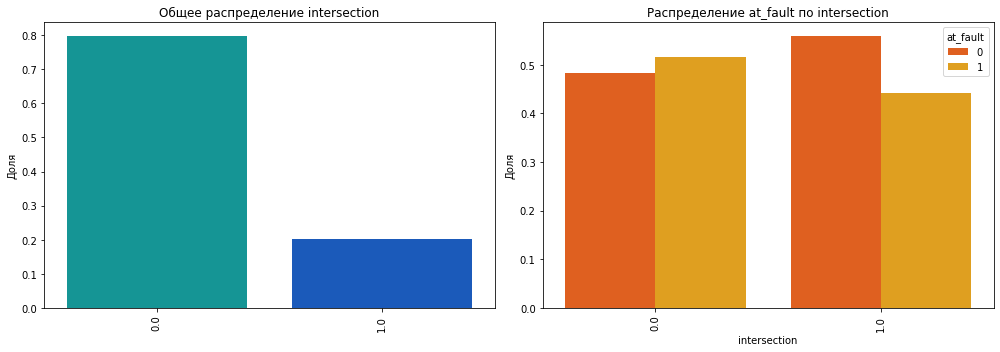

In [26]:
categorical('intersection')

До 20% зарегистрированных аварий на с участием машин произошло на перекрестках. Среди всех участников ДТП на перекрестках большинство — невиновные (жертвы или «вторые стороны»)

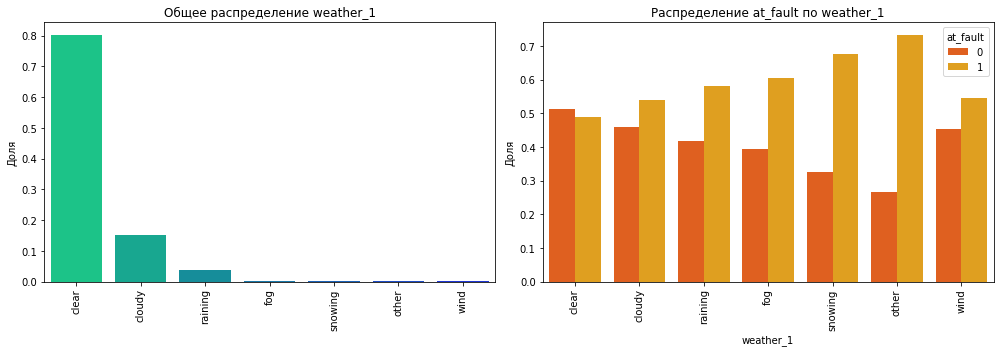

In [27]:
categorical('weather_1')

80% случаев погода была ясной , в 15% случаев облачной. Единсвтенный случай, когда доля невиновных выше чем виновных - это в ясную погоду. В случаях, с неуточненной погодой  доля виновных достигает более 70%. Так же в случае со снежной погодой - виновных почти 70%, в туман - 60%.

In [28]:
data['county_location'].value_counts().head(15)

los angeles       13911
orange             4718
san bernardino     3230
san diego          3139
riverside          2955
sacramento         1949
alameda            1488
santa clara        1442
ventura            1360
kern               1339
fresno             1003
san mateo           867
san joaquin         847
contra costa        828
sonoma              642
Name: county_location, dtype: int64

Как видно, большинство данных описывают ДТП в Лос-Анжелесе.

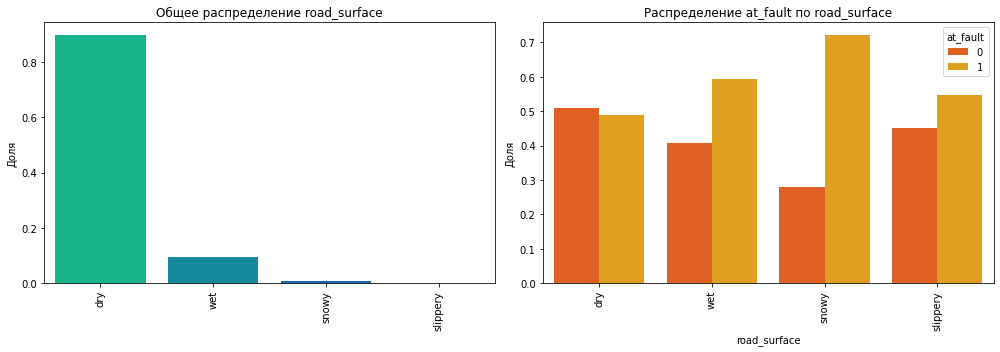

In [29]:
categorical('road_surface')

Почти в 90% случаев дорога была сухой. Самая редкая категория - скользкая дорога. В случае сухой дороги чаще всего участник невиновен, в остальных случаях чаще всего участник виновен, особенно при заснеженном состоянии дороги.

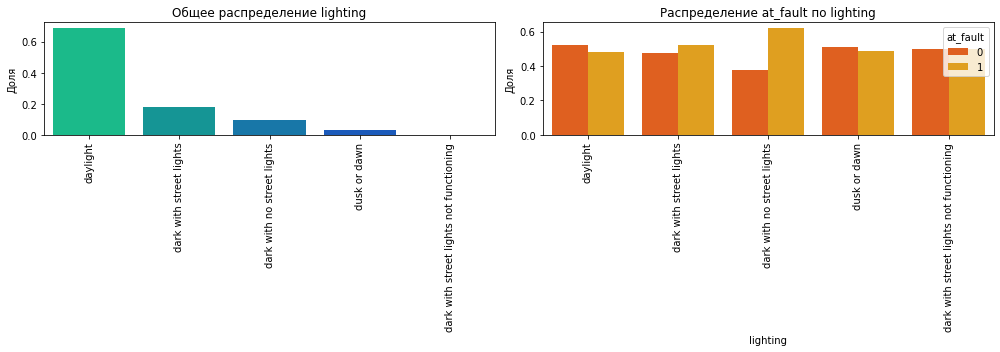

In [30]:
categorical('lighting')

Уредим категории.

In [31]:
lighting_mapping = {
    'daylight': 'light',
    'dusk or dawn': 'light',
    'dark with street lights': 'dark',
    'dark with street lights not functioning': 'dark',
    'dark with street lights': 'dark'
}
data['lighting'] = data['lighting'].map(lighting_mapping)

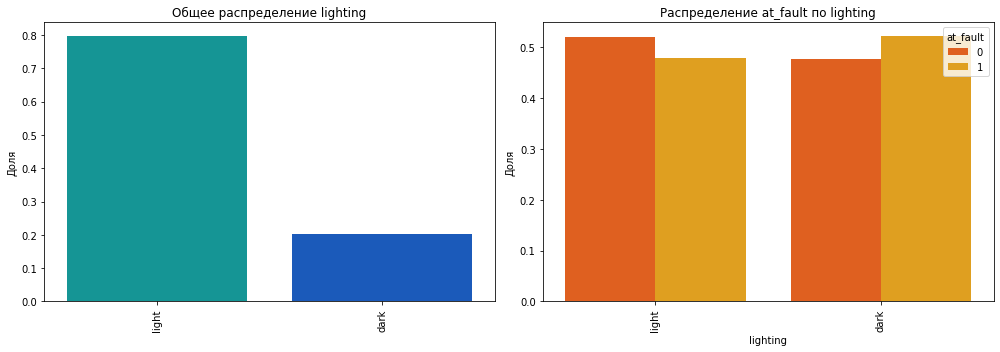

In [32]:
categorical('lighting')

В ~80% проишествия происходили в дневное время. Участники чаще виновны в дневное время. 

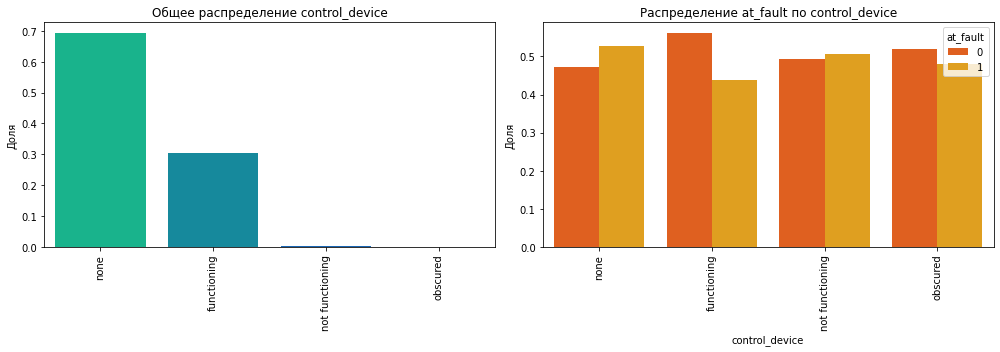

In [33]:
categorical('control_device')

В ~70% происшествий не зарегистрирована информация о работе регулирующих устройств, но зато данный столбец дает нам информацию о том, что при работающем светофоре участник ДТП виновен в ~60% случаев.

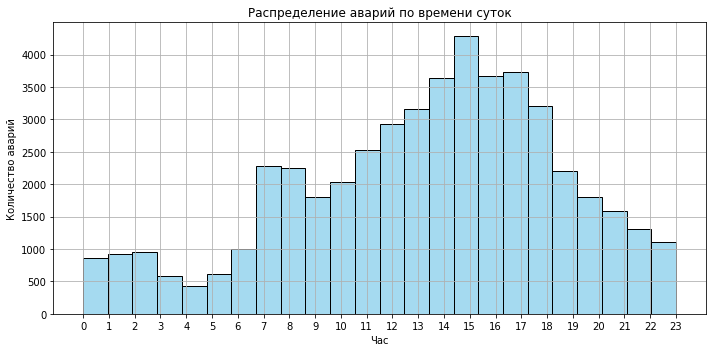

In [34]:
data['collision_time'] = pd.to_datetime(data['collision_time'], format='%H:%M:%S', errors='coerce')
data['collision_hour'] = pd.to_datetime(data['collision_time'], errors='coerce').dt.hour
plt.figure(figsize=(10, 5))
sns.histplot(data['collision_hour'].dropna(), bins=24, kde=False, color='skyblue')
plt.title('Распределение аварий по времени суток')
plt.xlabel('Час')
plt.ylabel('Количество аварий')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

Больше всего аварий происходит с 12 до 18 часов. Меньше всего с 0 до 6 утра.

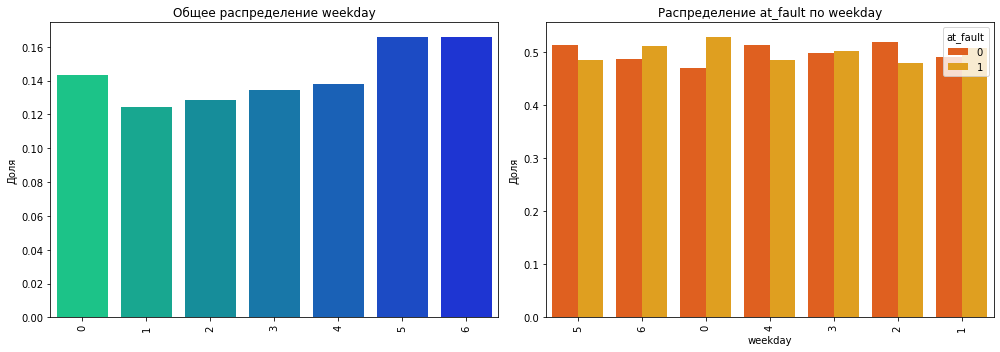

In [35]:
categorical('weekday')

Больше всего аварий с пятницы по воскресенье. Виноваты чаще всего те, кто попадает в аврии по вторникам, четвергам  и  пятницам. 

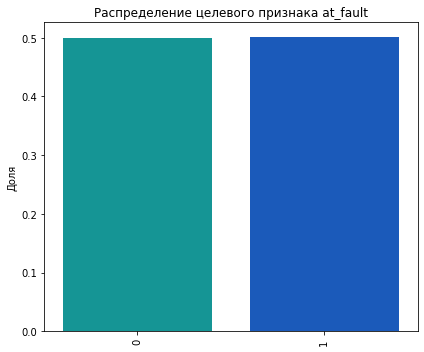

In [36]:
categorical('at_fault')

Отлично! Целевой признак сбалансирован.

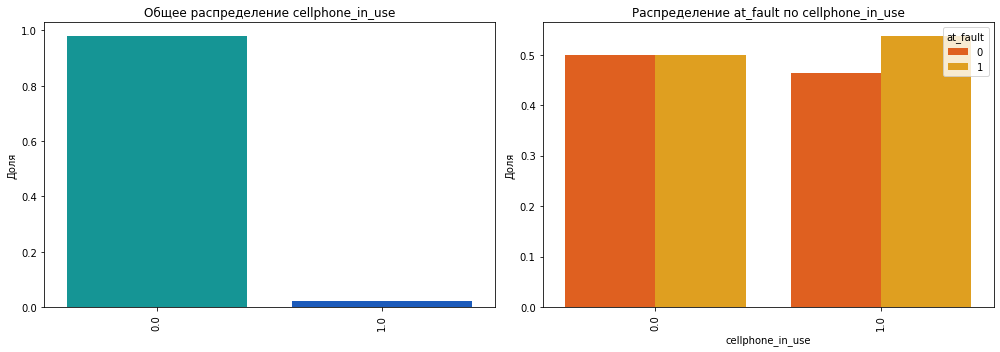

In [37]:
categorical('cellphone_in_use')

Водители в 98% случаев не говорили по телефону во время поездки. В случаях, когда говорили - в 60% случаях были виновны в ДТП.

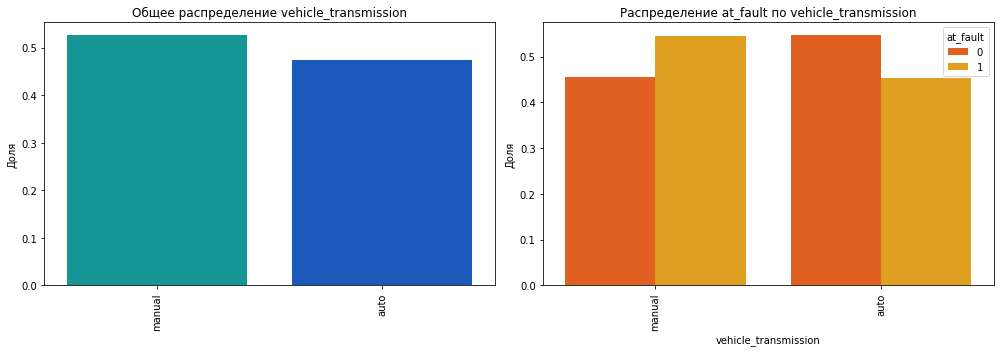

In [38]:
categorical('vehicle_transmission')

~55% машин имели ручную коробку передач. При ручной КП водители чаще виновны, чем при автоматической КП.

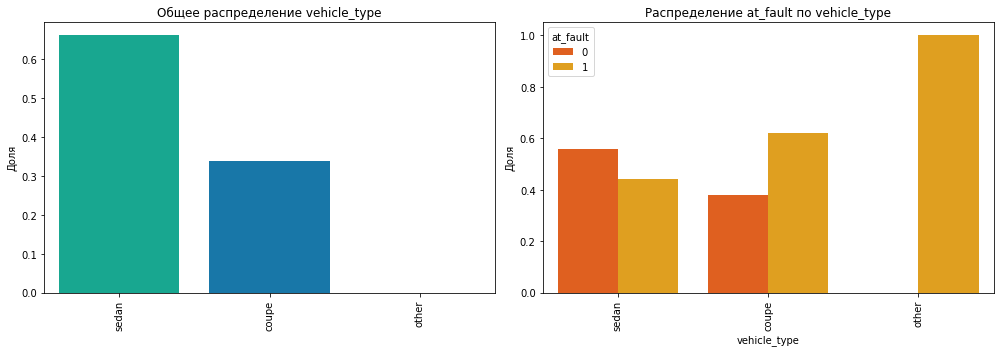

In [39]:
categorical('vehicle_type')

Большинство машин типа седан, водители машин типа купе чаще виновны в авариях. В 100% случаев виновны водители неуточненного типа машин.

Исследуем единственный количественные признаки.

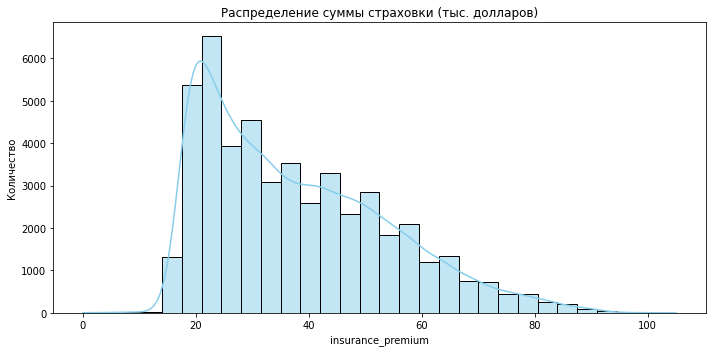

In [40]:
plt.figure(figsize=(10, 5))
sns.histplot(data['insurance_premium'], kde=True, bins=30, color='skyblue')
plt.title(f'Распределение суммы страховки (тыс. долларов)')
plt.xlabel('insurance_premium')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

Самая популярная сумма страховки от 20 до 40 тыс.долларов. 

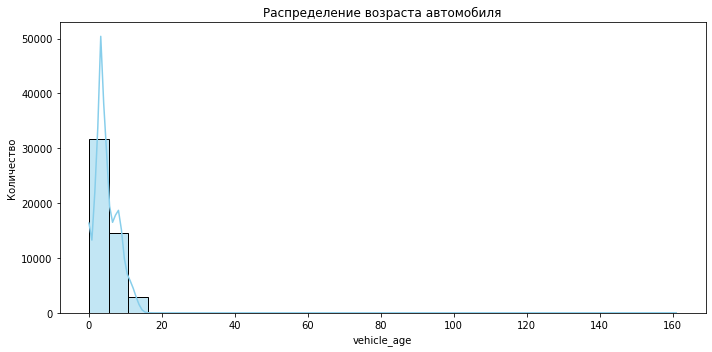

In [41]:
plt.figure(figsize=(10, 5))
sns.histplot(data['vehicle_age'], kde=True, bins=30, color='skyblue')
plt.title(f'Распределение возраста автомобиля')
plt.xlabel('vehicle_age')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

Точно, мы ранее уже находили этот выброс. Удалим. Так же удалим автомобили младше 10 лет.

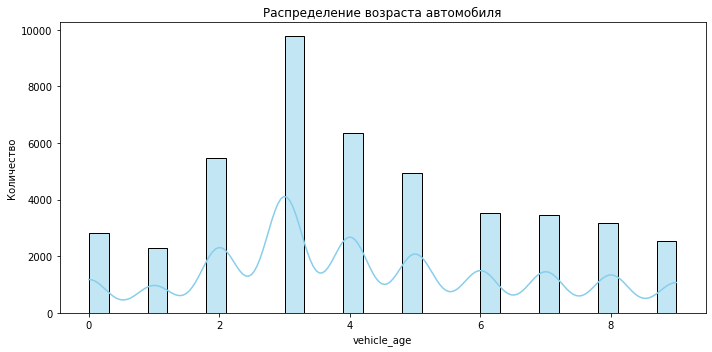

In [42]:
data = data[data['vehicle_age'] < 10]
plt.figure(figsize=(10, 5))
sns.histplot(data['vehicle_age'], kde=True, bins=30, color='skyblue')
plt.title(f'Распределение возраста автомобиля')
plt.xlabel('vehicle_age')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

Основаня масса автомобилей возрастом от 2 до 4.5 лет. Имеется длинный правый хвост свидетельствующий о том, что достаточно водителей с пожилыми машинами.

In [43]:
data = data.drop('collision_time', axis=1)

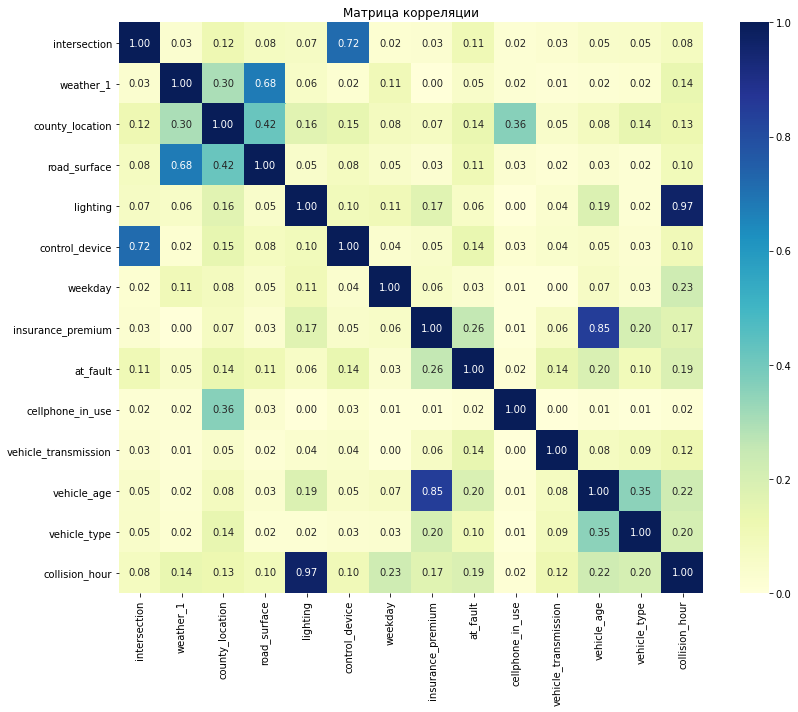

In [44]:
phik_matrix = data.phik_matrix(interval_cols=['vehicle_age'])
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, cmap='YlGnBu',annot=True, fmt='.2f', vmin=0, vmax=1)
plt.title("Матрица корреляции")
plt.tight_layout()
plt.show()

Удалим столбец `lighting`, так как он дает мультиколлинеарность с `collision_hour` и меньше зависит от целевого признака.

In [45]:
data = data.drop('lighting', axis=1)

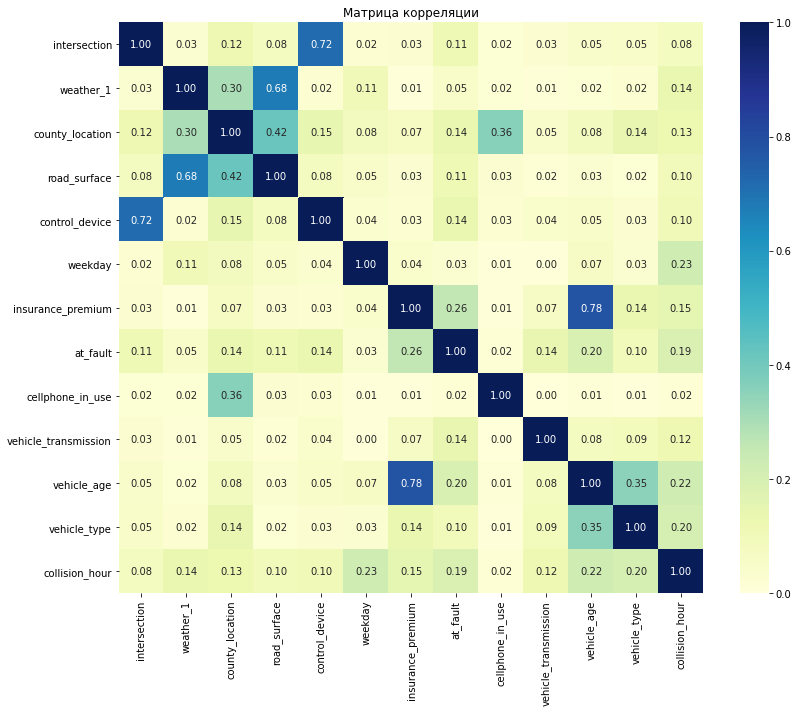

In [46]:
phik_matrix = data.phik_matrix(interval_cols=['vehicle_age','insurance_premium'])
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, cmap='YlGnBu',annot=True, fmt='.2f', vmin=0, vmax=1)
plt.title("Матрица корреляции")
plt.tight_layout()
plt.show()

Линейная зависимость признаков с целевым - слабая. Целевой признак слабо зависит от (по убыванию): суммы страховки, возраста автомобиля, часа суток, типа коробки передач.

**Вывод.**  
Создан датафрейм `data` содержащий информацию о ДТП с исходом серьезнее царапины 2012 года, где виновником была машина.
Дубликаты удалены. Удалены пропуски.    
Удалены данные об автомобилях старше 10 лет.
* Установлено: 1/5 всех ДТП происходит на перекрестках, погодные условия ясные, почти половина всех ДТП из-за превышения скорости, в 90% случаев дорога сухая, аварии происходят преимущественно в дневное время, преимущественно водитель трезвый, водитель почти никогда в момент аварии не говорит по телефону, 55% машин имеет ручную коробку передач, большинство машин типа седан, автомобили возрастом 2-4.5 года.   
* Портрет виновника: трезв, попадает в аварию не на перекрестке в неблагоприятную погоду в дневное время при нарушении маневра, дорога заснежена или влажная, инеформация о регулирующих устройствах не установлена, машина типа купер с ручной коробкой передач.   

Целевой признак идеально сбалансирован.   
Удален столбец `lighting` который давал мультиколлинеарность с `collision_hour`.
Целевой признак слабо зависит от (по убыванию):  суммы страховки, возраста автомобиля, часа суток, типа коробки передач.

Подготовим выборки.

In [47]:
X = data.drop(columns='at_fault')
y = data['at_fault']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=RANDOM_STATE)

In [49]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33259, 12)
(11087, 12)
(33259,)
(11087,)


Закодируем и замасштабируем признаки. Целевой признак итак числовой, его кодировать не будем. Так же кодированию не подлежат бинарные числовые признаки `intersection`, `cellphone_in_use`. Категориальные признаки закодируем OneHotEncoder, а числовые StandardScaler.

In [50]:
numeric = ['vehicle_age', 'insurance_premium']
passthrough = ['intersection', 'cellphone_in_use', 'weekday', 'collision_hour']
categorical = ['weather_1', 'road_surface', 'county_location','control_device', 'vehicle_transmission', 'vehicle_type']

preprocessor = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), numeric),
    ('pass', 'passthrough', passthrough),
     ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical)
])

## Промежуточный вывод

**Цель:** подготовить данные для создания модели оценки водительского риска
1. Отобраны признаки необходимые для модели, данные отфильтрованы за 2012 год, с последствиями аварии среьезнее, чем царапина;
2. Данные исследованы на дубликаты, все строки с пропусками удалены;
3. Проведен исследовательский анализ в ходе которого выявлен портрет виновника и самые частые причины ДТП;
4. Удалены данные об автомобилях старше 10 лет.
5. Данные разбиты на тестовую и целевые признаки, подготовлен препроцессор для кодирования и масштабирования признаков.

## Шаг 5. Найти лучшую модель

Перед нами стоит задача логистической регрессии. Оценим модели Logistic Regression, Decision Tree, XGBClassifier, LGBMClassifier. Для подбора параметров моделей используем Optuna, метрикой качества модели будет ROC-AUC так как она оценивает модель по всему диапазону порогового значения. Так же данная метрика дает возможность ранжировать клиентов по вероятности аварии. Дополнительно на тестовой выборке мы рассчитываем метрику F1 — она показывает баланс между точностью и полнотой при выбранном пороге и позволяет оценить практическую эффективность модели в условиях, когда важно не только отранжировать, но и принять бинарное решение (например, классифицировать клиента как виновного и выдать предупреждение, или наоборот — не предпринимать никаких действий).

In [51]:
def create_final_pipe(preprocessor):
    return {
        'LogisticRegression': {
            'model': Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(
                    random_state=RANDOM_STATE,
                    max_iter=1000, n_jobs=-1
                ))
            ]),
            'params': {
                'classifier__C': optuna.distributions.FloatDistribution(0.01, 10),
                'classifier__penalty': CategoricalDistribution(['l1', 'l2']),
                'classifier__solver': CategoricalDistribution(['liblinear']),

            }
        },
        'DecisionTreeClassifier': {
            'model': Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
            ]),
            'params': {
                'classifier__max_depth': IntDistribution(3, 20),
                'classifier__min_samples_split': IntDistribution(2, 20),
                'classifier__min_samples_leaf': IntDistribution(1, 10)
            }
        },
        'XGBClassifier': {
            'model': Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', xgb.XGBClassifier(
                    use_label_encoder=False,
                    eval_metric='logloss',
                    random_state=RANDOM_STATE, n_jobs=-1
                ))
            ]),
            'params': {
                'classifier__n_estimators': IntDistribution(50, 200),
                'classifier__max_depth': IntDistribution(3, 10),
                'classifier__learning_rate': FloatDistribution(0.01, 0.1),
                'classifier__subsample': FloatDistribution(0.5, 1.0),
                'classifier__colsample_bytree': FloatDistribution(0.5, 1.0),
                'classifier__scale_pos_weight': CategoricalDistribution([1.0])
            }
        },
        'LGBMClassifier': {
            'model': Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', lgb.LGBMClassifier(
                    random_state=RANDOM_STATE, n_jobs=-1
                ))
            ]),
            'params': {
                'classifier__n_estimators': IntDistribution(50, 200),
                'classifier__num_leaves': IntDistribution(10, 200),
                'classifier__learning_rate': FloatDistribution(0.01, 0.1)
            }
        }
    }

In [52]:
def train_best_model(X_train, y_train, final_pipe):
    best_model = None
    best_score = 0
    best_model_name = ""
    best_model_params = {}
    all_results = []

    for model_name, model_info in final_pipe.items():
        optuna_search = OptunaSearchCV(
            estimator=model_info['model'],
            param_distributions=model_info['params'],
            cv=3,
            n_trials=30,
            random_state=RANDOM_STATE,
            scoring='roc_auc',
            refit=True
        )
        optuna_search.fit(X_train, y_train)
        
        score = optuna_search.best_score_
        params = optuna_search.best_params_

        all_results.append({
            'Модель': model_name,
            'ROC-AUC (CV)': score,
            'Гиперпараметры': str(params)
        })

        if score > best_score:
            best_score = score
            best_model = optuna_search.best_estimator_
            best_model_name = model_name
            best_model_params = params

    df_results = pd.DataFrame(all_results)
    return best_model, best_score, best_model_name, best_model_params, df_results

def evaluate_model(model, X_test, y_test, best_score, best_model_name, best_model_params):
    print(f"\nЛучшей моделью по кросс-валидации является {best_model_name}")
    print(f"Лучшие гиперпараметры: {best_model_params}")
    print(f"CV ROC-AUC: {best_score:.4f}")

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    test_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC на тестовой выборке: {test_roc_auc_score:.4f}")

    y_pred = (y_pred_proba >= 0.5).astype(int)
    f1_score_value = f1_score(y_test, y_pred, pos_label=1)
    print(f"F1 на тестовой выборке: {f1_score_value:.4f}")
    
def main(X_train, y_train, X_test, y_test, data_preprocessor):
    final_pipe = create_final_pipe(data_preprocessor)
    best_model, best_score, best_model_name, best_model_params, df_results = train_best_model(
        X_train, y_train, final_pipe)
    evaluate_model(best_model, X_test, y_test, best_score, best_model_name, best_model_params)
    return best_model, df_results

In [53]:
%%time
model, df_results = main(X_train, y_train, X_test, y_test, preprocessor)

/tmp/ipykernel_103/1031480410.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-07-18 00:01:19,885] A new study created in memory with name: no-name-346f17f2-98cf-45b3-ab52-04698d70ba69
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-18 00:01:21,575] Trial 0 finished with value: 0.6702406316805152 and parameters: {'classifier__C': 4.552463511691507, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}. Best is trial 0 with value: 0.6702406316805152.
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-18 


Лучшей моделью по кросс-валидации является XGBClassifier
Лучшие гиперпараметры: {'classifier__n_estimators': 190, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.0488167052487713, 'classifier__subsample': 0.6951758539577131, 'classifier__colsample_bytree': 0.6538938533531814, 'classifier__scale_pos_weight': 1.0}
CV ROC-AUC: 0.6921
ROC-AUC на тестовой выборке: 0.6864
F1 на тестовой выборке: 0.6290
CPU times: user 34min 47s, sys: 21 s, total: 35min 8s
Wall time: 35min 33s


Лучшей моделью является ** XGBClassifie** с параметрами:'classifier__n_estimators': 190, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.0488, 'classifier__subsample': 0.6951, 'classifier__colsample_bytree': 0.6538, 'classifier__scale_pos_weight': 1.0 и **ROC-AUC: 0.6921**. 

Значение **ROC-AUC на тестовых данных: 0.6864**
Значение **F1 на тестовых данных: 0.6290**

In [60]:
display(df_results.sort_values(by='ROC-AUC (CV)', ascending=False))

,Модель,ROC-AUC (CV),Гиперпараметры
2,XGBClassifier,0.692078,"{'classifier__n_estimators': 190, 'classifier_..."
3,LGBMClassifier,0.690702,"{'classifier__n_estimators': 152, 'classifier_..."
1,DecisionTreeClassifier,0.673957,"{'classifier__max_depth': 5, 'classifier__min_..."
0,LogisticRegression,0.671243,"{'classifier__C': 0.08698962607801561, 'classi..."


## Промежуточный вывод

**Цель:** найти лучшую модель.  
1. Обучено 4 модели: LogisticRegression, DecisionTreeClassifier, LGBMClassifier, XGBClassifier.
2. Для выбора лучше модели использовалана метрика ROC-AUC, она позволяет сравнивать модели по качеству ранжирования, модель с более высоким ROC-AUC лучше отделяет водителей с высоким риском от низкого — независимо от порога.
3. Лучшей моделью является XGBClassifier с n_estimators=190, max_depth=4, learning_rate= 0.049.
4. ROC_AUC на тестовых данных составил : 0.6864 , а F1: 0.6290.

## Шаг 6. Проверить лучшую модель в работе

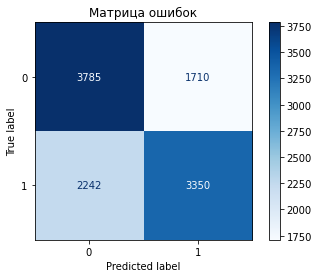

In [55]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Матрица ошибок")
plt.show()

In [56]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy:  {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall:    {recall:.3f}')
print(f'F1-score:  {f1:.3f}')

Accuracy:  0.644
Precision: 0.662
Recall:    0.599
F1-score:  0.629


Precision 66% — из всех "опасных" предсказаний, больше половины действительно были ДТП.  
Recall 60% — пропускает 40% реальных ДТП.

Думаю имеет смысл сместить порог классификации так, чтобы повысить recall и снизить precision после оценки возможных убытков.

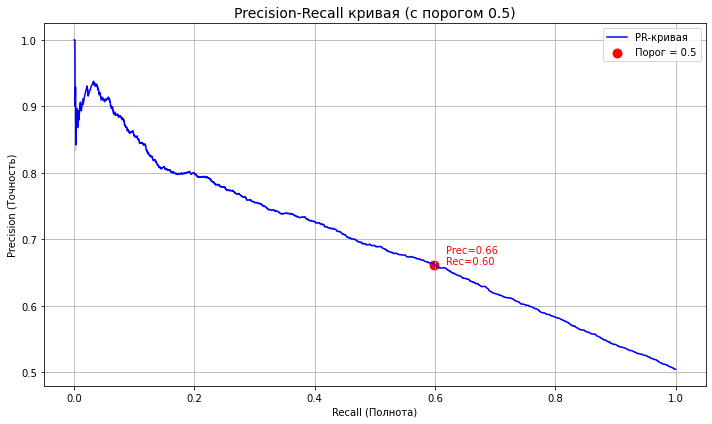

In [57]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
threshold_idx = np.argmin(np.abs(thresholds - 0.5)) 
pr_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=pr_df, x='Recall', y='Precision', label='PR-кривая', color='blue')

plt.scatter(recall[threshold_idx], precision[threshold_idx], color='red', s=80, label='Порог = 0.5')
plt.text(recall[threshold_idx] + 0.02, precision[threshold_idx],
         f'Prec={precision[threshold_idx]:.2f}\nRec={recall[threshold_idx]:.2f}',
         color='red', fontsize=10)

plt.title('Precision-Recall кривая (с порогом 0.5)', fontsize=14)
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.grid(True)

plt.legend()
plt.tight_layout()
plt.show()

При повышении точности, полнота снижается. 

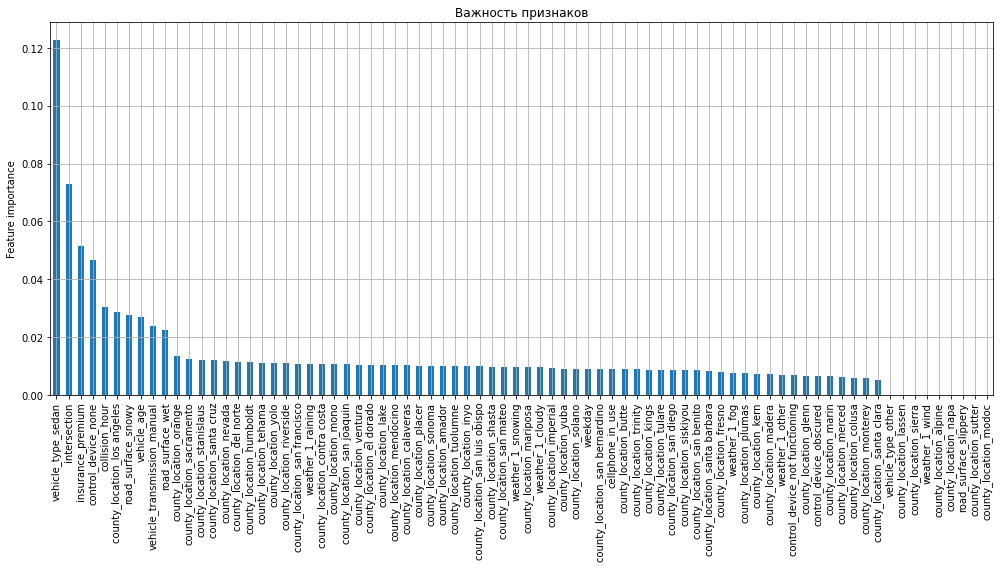

In [58]:
preprocessor = model.named_steps['preprocessor']

feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if name == 'cat': 
        ohe_feature_names = transformer.get_feature_names_out(columns)
        feature_names.extend(ohe_feature_names)
    elif name == 'scale': 
        feature_names.extend(columns)
    elif name == 'pass':  
        feature_names.extend(columns)

if preprocessor.remainder == 'passthrough':
    passthrough_cols = preprocessor.transformers_[-1][2]
    feature_names.extend(passthrough_cols)

feature_names = [str(f) for f in feature_names]

importances = model.named_steps['classifier'].feature_importances_

importances_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

importances_series.plot(kind='bar', figsize=(14, 8))
plt.title('Важность признаков')
plt.ylabel('Feature importance')
plt.grid(True)
plt.tight_layout()
plt.show()

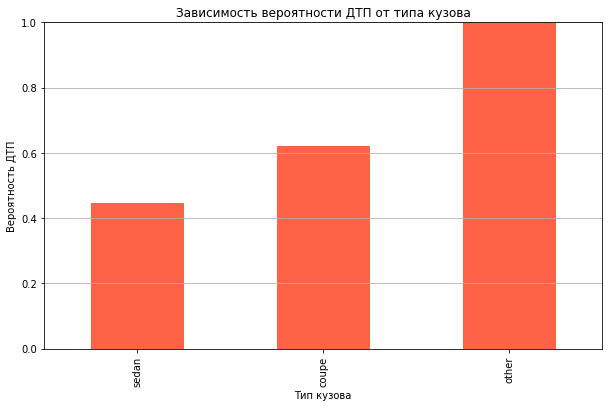

In [59]:
risk_by_sobriety = data.groupby('vehicle_type')['at_fault'].mean().sort_values()

risk_by_sobriety.plot(kind='bar', figsize=(10,6), color='tomato')
plt.ylabel('Вероятность ДТП')
plt.xlabel('Тип кузова')
plt.title('Зависимость вероятности ДТП от типа кузова')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

Очевидно, что вероятность ДТП для водителей седанов значительно ниже чем для остальных.

**<u>Предложения:</u>**
- **Анализ аварийности по типам кузова:** Внедрить регулярную аналитику по ДТП в зависимости от типа машины. Отчёты передавать владельцам автопарков и использовать при принятии решений о закупках.
- **Скидки при страховании:** Договориться со страховщиками о скидках на страховку для седанов, что сделает их эксплуатацию дешевле для компании.
- **Мотивация пользователей:**Предлагать бонусы или скидки за выбор седана при бронировании.
- **Умная сортировка автомобилей в приложении:** седаны — выше в списке, компактные и кроссоверы — ниже.
- **Ограничение доступа к высокорисковым моделям:** Если по данным модели машин типа X чаще происходят аварии, постепенно ограничить их выдачу новым пользователям или в ночное время.
- **Переход при обновлении автопарка:** Включить в корпоративную политику пункт: покупка только седанов или моделей с пониженной аварийностью.

## Промежуточный вывод

**Цель:** проверить лучшую модель.   
1. На основании матрицы ошибок установлено, что модель ловит 67% реальных виновников, так же в 40% случаев оценивает поедку, как рискованую, хотя это не соответсвует действительнсти.
2. Модель дает верную оценку в 63% случаев.
3. Возможно, в будущем будет эффективно сдвинуть порог классификации.
4. Самый важный признак для модели оказался `vehicle_type_sedan`, у водителей седана вероятность быть виновными 40%, у купера за 60% у остальных почти 100%.

## Выводы

В рамках проекта была построена система машинного обучения для оценки вероятности попадания водителя в ДТП. Лучшей моделью оказался **XGBClassifier с параметрами n_estimators=190, max_depth=4, learning_rate=0.049, показавший ROC-AUC = 0.6864 и F1 = 0.6290 на тестовых данных**.

Наиболее значимым фактором модели оказался тип кузова (vehicle_type): вероятность быть виновным в ДТП у водителя седана почти в 2,5 раза ниже, чем у остальных. Это подтверждает, что включение таких признаков в анализ критично для безопасности.

**Возможность создания адекватной системы**
Результаты показывают, что создание адекватной модели оценки риска при выдаче автомобиля возможно. Даже на ограниченном наборе признаков система способна эффективно ранжировать водителей по уровню риска, выявляя потенциально опасных с высокой чувствительностью. Такая модель может быть использована, например, в каршеринге или страховании для динамического управления рисками.

**Для повышения точности модели стоит собирать дополнительные признаки, такие как:**
- История нарушений ПДД и количество предыдущих ДТП;
- Усталость/время за рулем (через телематические данные);
- Состояние водителя в реальном времени (сонливость, отвлечение, эмоциональное состояние);
- Погодные условия и дорожная обстановка на момент бронирования;
- Поведение при аренде (частота отмен, частота коротких поездок, время суток и т.д.);
- Информация с датчиков автомобиля — резкие торможения, ускорения, превышение скорости.

**Промежуточные итоги проекта:**
1. Загружены и проанализированы таблицы SQL, удалены лишние и некорректные данные.
2. Проведен EDA: выявлены портрет виновника и статистические зависимости (например, повышенный риск для новых машин и нетрезвых водителей).
3. Подготовлены данные, отобраны значимые признаки, обучены и сравнины несколько моделей.
4. Построена и протестирована финальная модель XGBClassifier.
5. Выявлен ключевой фактор риска — трезвость водителя. Предложены технические решения по снижению риска (алкотестер, камера, телеметрия).

**Вывод:
Модель показывает высокую способность различать водителей с повышенным риском ДТП. Если подключить модель к реальным сервисам вроде страхования или каршеринга, она поможет заранее выявлять рискованных водителей, выдавать им предупреждения, ограничивать доступ к авто или менять условия аренды в зависимости от степени риска. Расширение набора факторов и подключение телеметрии усилит эффективность модели.**